## Installing External Packages

In [283]:
!pip install shap

In [279]:
pip install category_encoders

In [281]:
!pip install catboost

In [299]:
!pip install kmodes

## Imports

In [224]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
%matplotlib inline

In [280]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [282]:
from catboost import CatBoostClassifier, cv,Pool

In [284]:
import shap
shap.initjs()

## Getting the Data

In [225]:
train = pd.read_csv('/content/drive/MyDrive/ml competition/av_job_a_thon/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ml competition/av_job_a_thon/test.csv')

In [226]:
train.columns = train.columns.str.strip().str.lower()

In [227]:
response_rate = lambda data: data['response'].sum()*100/data['response'].count()

In [228]:
test.columns = test.columns.str.strip().str.lower()

In [229]:
#city_code = train['city_code'].value_counts().reset_index().rename(columns={'city_code':'city_code_counts'})

In [230]:
#train = pd.merge(left= train, right = city_code, left_on='city_code', right_on='index',how='left')
#test = pd.merge(left= test, right = city_code, left_on='city_code', right_on='index',how='left')

In [231]:
#train['city_code'] = np.where(train['city_code_counts']<1000,'CO',
#                              train['city_code'])
#test['city_code'] = np.where(test['city_code_counts']<1000,'CO',
#                              test['city_code'])

The if the relation of other policy holder is spouse then lower age should be greater than 18.

In [232]:
train['lower_age'] = np.where((train['is_spouse']=='Yes')&(train['lower_age']<18), np.nan, train['lower_age'])
test['lower_age'] = np.where((test['is_spouse']=='Yes')&(test['lower_age']<18), np.nan, test['lower_age'])

In [233]:
lower_age_grouped = train.groupby(['city_code','accomodation_type','reco_insurance_type'])['lower_age'].median().reset_index()

In [234]:
def fill_lower_age(data):
  condition = ((lower_age_grouped['city_code'] == data['city_code'])&
               (lower_age_grouped['accomodation_type'] == data['accomodation_type'])&
               (lower_age_grouped['reco_insurance_type']== data['reco_insurance_type']))
  return lower_age_grouped[condition]['lower_age'].values[0]

In [235]:
train['lower_age'] = train.apply(lambda data: fill_lower_age(data) if np.isnan(data['lower_age']) else data['lower_age'],axis=1)
test['lower_age'] = test.apply(lambda data: fill_lower_age(data) if np.isnan(data['lower_age']) else data['lower_age'],axis=1)

Filling the poplicy vintage 0 for non customers and clubbing >10 years to 10 years.

In [236]:
train['holding_policy_duration'].fillna(0, inplace=True)
test['holding_policy_duration'].fillna(0, inplace=True)

In [237]:
train['holding_policy_duration'] = np.where(train['holding_policy_duration'].isin(['10.0','11.0','12.0','13.0','14.0','14+']),
                                            10, train['holding_policy_duration'])
test['holding_policy_duration'] = np.where(test['holding_policy_duration'].isin(['10.0','11.0','12.0','13.0','14.0','14+']),
                                            10, test['holding_policy_duration'])

In [238]:
train['holding_policy_duration'] = train['holding_policy_duration'].astype(str).str.split('.').str[0]
test['holding_policy_duration'] = test['holding_policy_duration'].astype(str).str.split('.').str[0]

In [239]:
train['holding_policy_duration'] = train['holding_policy_duration'].astype(int)
train['holding_policy_duration'] = pd.Categorical(train['holding_policy_duration'])

test['holding_policy_duration'] = test['holding_policy_duration'].astype(int)
test['holding_policy_duration'] = pd.Categorical(test['holding_policy_duration'])

In [240]:
train['holding_policy_type'].value_counts(dropna=False)

NaN    20251
3.0    13279
1.0     8173
2.0     5005
4.0     4174
Name: holding_policy_type, dtype: int64

In [241]:
test['holding_policy_type'].value_counts(dropna=False)

NaN    8603
3.0    5572
1.0    3574
2.0    2150
4.0    1906
Name: holding_policy_type, dtype: int64

Creating a category 0 for the non customers of holding policy type.

In [242]:
train['holding_policy_type'].fillna(0.0,inplace=True)
test['holding_policy_type'].fillna(0.0,inplace=True)

In [244]:
train['holding_policy_type'].value_counts(dropna=False)

0.0    20251
3.0    13279
1.0     8173
2.0     5005
4.0     4174
Name: holding_policy_type, dtype: int64

In [243]:
test['holding_policy_type'].value_counts(dropna=False)

0.0    8603
3.0    5572
1.0    3574
2.0    2150
4.0    1906
Name: holding_policy_type, dtype: int64

In [245]:
train['holding_policy_type'] = train['holding_policy_type'].astype(int)
test['holding_policy_type'] = test['holding_policy_type'].astype(int)

In [246]:
train['holding_policy_type'].value_counts(dropna=False)

0    20251
3    13279
1     8173
2     5005
4     4174
Name: holding_policy_type, dtype: int64

In [247]:
test['holding_policy_type'].value_counts(dropna=False)

0    8603
3    5572
1    3574
2    2150
4    1906
Name: holding_policy_type, dtype: int64

In [248]:
train['holding_policy_type'] = pd.Categorical(train['holding_policy_type'])
test['holding_policy_type'] = pd.Categorical(test['holding_policy_type'])

In [249]:
#reco_policy_cat = train['reco_policy_cat'].value_counts().reset_index().rename(columns={'reco_policy_cat':'reco_policy_counts'})

In [250]:
#train = pd.merge(left= train, right = reco_policy_cat, left_on='reco_policy_cat', right_on='index',how='left')
#test = pd.merge(left= test, right = reco_policy_cat, left_on='reco_policy_cat', right_on='index',how='left')

In [251]:
#train['reco_policy_cat'] = np.where(train['reco_policy_counts']<1000,'CO',
#                              train['reco_policy_cat'])
#test['reco_policy_cat'] = np.where(test['reco_policy_counts']<1000,'CO',
#                              test['reco_policy_cat'])

In [252]:
train.isnull().sum()

id                             0
city_code                      0
region_code                    0
accomodation_type              0
reco_insurance_type            0
upper_age                      0
lower_age                      0
is_spouse                      0
health indicator           11691
holding_policy_duration        0
holding_policy_type            0
reco_policy_cat                0
reco_policy_premium            0
response                       0
dtype: int64

In [253]:
test.isnull().sum()

id                            0
city_code                     0
region_code                   0
accomodation_type             0
reco_insurance_type           0
upper_age                     0
lower_age                     0
is_spouse                     0
health indicator           5027
holding_policy_duration       0
holding_policy_type           0
reco_policy_cat               0
reco_policy_premium           0
dtype: int64

Mapping the binary columns. Some of the code is inherited from my Logistic regression notebook :D

In [254]:
train['accomodation_type'] = train['accomodation_type'].map({'Rented':0, 'Owned':1}) 
train['reco_insurance_type'] = train['reco_insurance_type'].map({'Individual':0, 'Joint':1})
train['is_spouse'] = train['is_spouse'].map({'No':0, 'Yes':1})

test['accomodation_type'] = test['accomodation_type'].map({'Rented':0, 'Owned':1}) 
test['reco_insurance_type'] = test['reco_insurance_type'].map({'Individual':0, 'Joint':1})
test['is_spouse'] = test['is_spouse'].map({'No':0, 'Yes':1})

In [255]:
train['upper_age'] = train['upper_age'].astype(float)
test['upper_age'] = test['upper_age'].astype(float)

train['lower_age'] = train['lower_age'].astype(float)
test['lower_age'] = test['lower_age'].astype(float)

In [256]:
train['upper_age'].describe()

count    50882.000000
mean        44.856275
std         17.310271
min         18.000000
25%         28.000000
50%         44.000000
75%         59.000000
max         75.000000
Name: upper_age, dtype: float64

Bucketing the ages, will use them for imputing

In [257]:
train['upper_age2'] = np.where(train['upper_age']<=35,'18-35',
                          np.where(train['upper_age']<=45,'35-45',
                                   np.where(train['upper_age']<=55,'45-55',
                                            '55+')))
train['lower_age2'] = np.where(train['lower_age']<=35,'18-35',
                          np.where(train['lower_age']<=45,'35-45',
                                   np.where(train['lower_age']<=55,'45-55',
                                            '55+')))

test['upper_age2'] = np.where(test['upper_age']<=35,'18-35',
                          np.where(test['upper_age']<=45,'35-45',
                                   np.where(test['upper_age']<=55,'45-55',
                                            '55+')))
test['lower_age2'] = np.where(test['lower_age']<=35,'18-35',
                          np.where(test['lower_age']<=45,'35-45',
                                   np.where(test['lower_age']<=55,'45-55',
                                            '55+')))

In [258]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [259]:
confusion_matrix = pd.crosstab(train['city_code'], train['region_code'])

In [260]:
cramers_corrected_stat(confusion_matrix)

0.9466557046614136

In [261]:
health_indicator = pd.concat([train,test]).groupby(['upper_age2','lower_age2','reco_policy_cat'])['health indicator'].agg(pd.Series.mode).reset_index()

In [262]:
health_indicator['health indicator'].str.len().value_counts()

2    238
0      5
3      4
Name: health indicator, dtype: int64

In [263]:
health_indicator['health indicator'] = health_indicator['health indicator'].astype(str)

In [264]:
health_indicator[health_indicator['health indicator'].str.len()!=2]

,upper_age2,lower_age2,reco_policy_cat,health indicator
27,18-35,35-45,21,['X2' 'X4' 'X8']
28,18-35,35-45,22,['X2' 'X6']
33,35-45,18-35,3,['X2' 'X4']
40,35-45,18-35,10,['X2' 'X4']
48,35-45,18-35,18,['X1' 'X4']
51,35-45,18-35,21,['X1' 'X2']
78,35-45,55+,16,['X1' 'X4']
80,35-45,55+,18,['X2' 'X4']
82,35-45,55+,22,['X1' 'X4']
111,45-55,35-45,7,['X2' 'X4']


In [265]:
health_indicator['health indicator'] = np.where(health_indicator['health indicator'].str.len()!=2,'X1',health_indicator['health indicator'])

In [266]:
health_indicator['health indicator'] = np.where(health_indicator['health indicator']=='[]','X1',health_indicator['health indicator'])

In [267]:
health_indicator[health_indicator['health indicator'].str.len()!=2]

,upper_age2,lower_age2,reco_policy_cat,health indicator


In [268]:
health_indicator['health indicator'].value_counts()

X1    173
X2     49
X3     13
X4     10
X6      2
Name: health indicator, dtype: int64

In [269]:
def fill_health_indicator(data):
  condition = ((health_indicator['upper_age2'] == data['upper_age2'])&
               (health_indicator['lower_age2']== data['lower_age2'])&
               (health_indicator['reco_policy_cat']== data['reco_policy_cat']))
  return health_indicator[condition]['health indicator'].values[0]

In [270]:
train['health indicator'] = train['health indicator'].astype(str)
test['health indicator'] = test['health indicator'].astype(str)

In [271]:
train['health indicator'].value_counts()

X1     13010
nan    11691
X2     10332
X3      6762
X4      5743
X5      1727
X6      1280
X7       196
X8        78
X9        63
Name: health indicator, dtype: int64

In [272]:
train1 = train[train['health indicator']=='nan'].copy()
train2 = train[train['health indicator']!='nan'].copy()

test1 = test[test['health indicator']=='nan'].copy()
test2 = test[test['health indicator']!='nan'].copy()

In [273]:
train1 = pd.merge(left = train1, right = health_indicator, on=['upper_age2','lower_age2','reco_policy_cat'],how='left')
test1 = pd.merge(left = test1, right = health_indicator, on=['upper_age2','lower_age2','reco_policy_cat'],how='left')

In [274]:
train1.rename(columns={'health indicator_y':'health indicator'},inplace=True)
test1.rename(columns={'health indicator_y':'health indicator'},inplace=True)

In [275]:
train1.drop('health indicator_x',axis=1,inplace=True)
test1.drop('health indicator_x',axis=1,inplace=True)

In [276]:
train = pd.concat([train1,train2])
test = pd.concat([test1,test2])

In [277]:
train.isnull().sum()

id                         0
city_code                  0
region_code                0
accomodation_type          0
reco_insurance_type        0
upper_age                  0
lower_age                  0
is_spouse                  0
holding_policy_duration    0
holding_policy_type        0
reco_policy_cat            0
reco_policy_premium        0
response                   0
upper_age2                 0
lower_age2                 0
health indicator           0
dtype: int64

In [278]:
test.isnull().sum()

id                         0
city_code                  0
region_code                0
accomodation_type          0
reco_insurance_type        0
upper_age                  0
lower_age                  0
is_spouse                  0
holding_policy_duration    0
holding_policy_type        0
reco_policy_cat            0
reco_policy_premium        0
upper_age2                 0
lower_age2                 0
health indicator           0
dtype: int64

In [285]:
premium_mean_median = train.groupby(['city_code','upper_age2','lower_age2','holding_policy_type'])['reco_policy_premium'].agg(['median','min','max']).reset_index().rename(columns={'median':'premium_median','min':'premium_min','max':'premium_max'})

In [286]:
train = pd.merge(left = train, right = premium_mean_median, on = ['city_code','upper_age2','lower_age2','holding_policy_type'],
                 how='left')

In [287]:
test = pd.merge(left = test, right = premium_mean_median, on = ['city_code','upper_age2','lower_age2','holding_policy_type'],
                 how='left')

In [288]:
train.head()

,id,city_code,region_code,accomodation_type,reco_insurance_type,upper_age,lower_age,is_spouse,holding_policy_duration,holding_policy_type,reco_policy_cat,reco_policy_premium,response,upper_age2,lower_age2,health indicator,premium_median,premium_min,premium_max
0,3,C5,3732,1,0,32.0,32.0,0,1,1,19,7450.0,1,18-35,18-35,X1,10440.0,4278.0,20736.0
1,7,C3,679,1,0,28.0,28.0,0,0,0,17,10640.0,0,18-35,18-35,X1,8124.0,2548.0,21900.0
2,10,C1,530,1,1,59.0,26.0,1,7,4,18,21100.8,1,55+,18-35,X1,25536.4,20955.0,39094.4
3,13,C7,3453,1,0,66.0,66.0,0,1,2,20,17192.0,1,55+,55+,X1,18176.0,11740.0,34380.8
4,20,C20,973,1,0,27.0,27.0,0,0,0,4,8050.0,0,18-35,18-35,X1,6876.0,2528.0,21577.6


In [289]:
train[['premium_median','reco_policy_premium', 'premium_min','premium_max']].corr()

,premium_median,reco_policy_premium,premium_min,premium_max
premium_median,1.000000,0.811861,0.952405,0.803166
reco_policy_premium,0.811861,1.000000,0.769959,0.678595
premium_min,0.952405,0.769959,1.000000,0.650122
premium_max,0.803166,0.678595,0.650122,1.000000


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


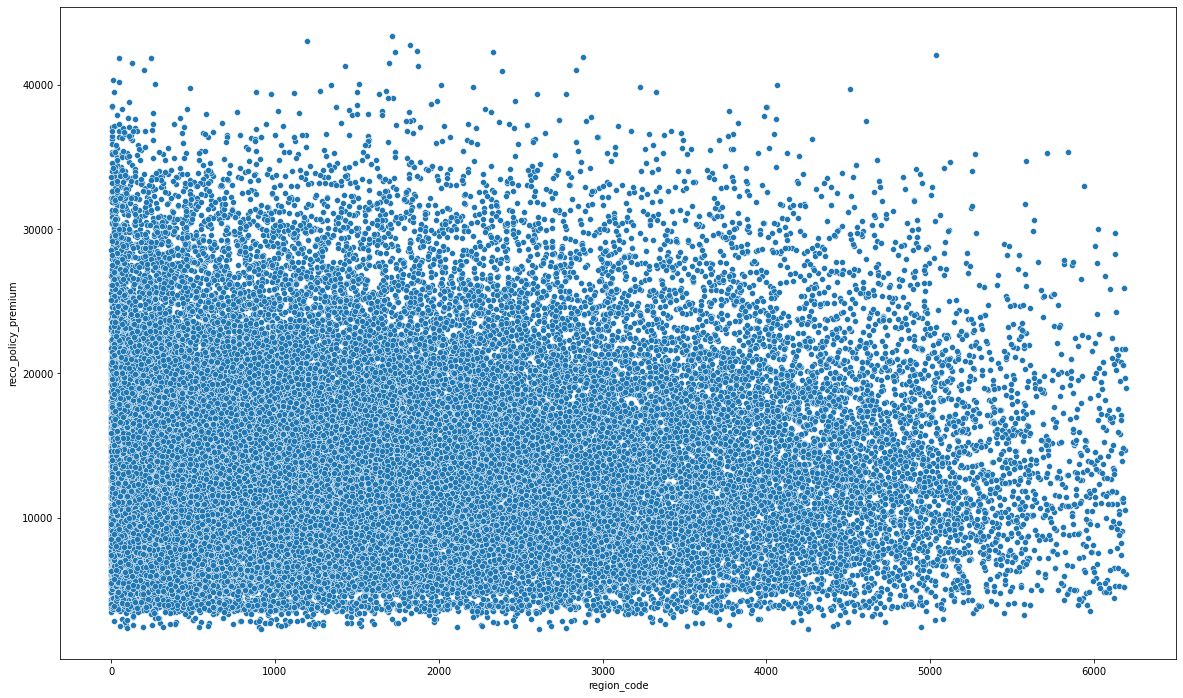

In [290]:
plt.figure(figsize=(20,12))
sns.scatterplot(train['region_code'], train['reco_policy_premium'])

In [291]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

Let us create features using clustering

In [292]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
X_ = pd.concat([train[['region_code','reco_policy_premium']],test[['region_code','reco_policy_premium']]]) 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_)
    kmeanModel.fit(X_)
 
    distortions.append(sum(np.min(cdist(X_, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X_, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_.shape[0]
    mapping2[k] = kmeanModel.inertia_

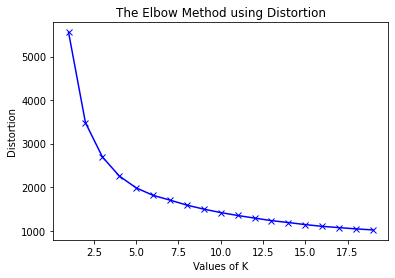

In [293]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [294]:
X_ = pd.concat([train[['id','region_code','reco_policy_premium']],test[['id','region_code','reco_policy_premium']]])
X_['id'] = X_['id'].astype(int)
kmean = KMeans(n_clusters=5,)
kmean.fit(X_[['region_code','reco_policy_premium']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [295]:
X_['classes'] = kmean.predict(X_[['region_code','reco_policy_premium']])

In [296]:
train = pd.merge(left=train, right = X_[['id','classes']], on='id', how='left')
test = pd.merge(left=test, right = X_[['id','classes']], on='id', how='left')

In [297]:
train.groupby('classes').apply(lambda data: data['response'].sum()*100/data['response'].count())

classes
0    24.311871
1    23.504685
2    23.758229
3    24.977883
4    24.245268
dtype: float64

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


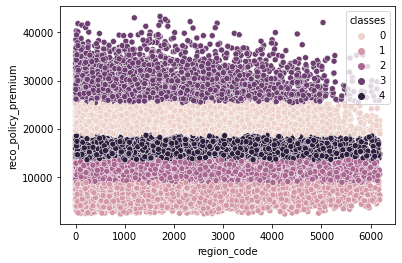

In [298]:
sns.scatterplot(train['region_code'], train['reco_policy_premium'], hue ='classes',data=train)

In [300]:
# Importing Libraries

from kmodes.kmodes import KModes

In [301]:
X_ = pd.concat([train[['reco_policy_cat','holding_policy_type','health indicator']],test[['reco_policy_cat','holding_policy_type','health indicator']]])

In [306]:
X_ = pd.concat([train[['reco_policy_cat','holding_policy_type','health indicator']],test[['reco_policy_cat','holding_policy_type','health indicator']]])
for col in X_.columns:
  categories = sorted(X_[col].unique().tolist())
  X_[col] =  pd.Categorical(X_[col],categories=categories)
X_ = pd.get_dummies(X_, drop_first=True)

i=1
cost = []
for num_clusters in list(range(1,20)):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 1, verbose=False)
    kmode.fit_predict(X_)
    cost.append(kmode.cost_)
    print(i)
    i=i+1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


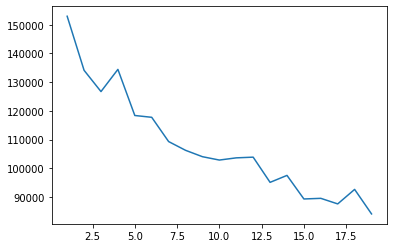

In [307]:
__ = np.array([i for i in range(1,20,1)])
plt.plot(__,cost)

In [319]:
X_ = pd.concat([train[['id','reco_policy_cat','holding_policy_type','health indicator']],test[['id','reco_policy_cat','holding_policy_type','health indicator']]])
X_['id'] = X_['id'].astype(int)
cat1 = sorted(X_['reco_policy_cat'].unique().tolist())
cat2 = sorted(X_['holding_policy_type'].unique().tolist())
cat3 = sorted(X_['health indicator'].unique().tolist())
X_['reco_policy_cat'] = pd.Categorical(X_['reco_policy_cat'],categories=cat1)
X_['holding_policy_type'] = pd.Categorical(X_['holding_policy_type'],categories=cat2)
X_['health indicator'] = pd.Categorical(X_['health indicator'],categories=cat3)
X_ = pd.get_dummies(X_, drop_first=True)
kmode = KModes(n_clusters=15, init = "Huang", n_init = 1, verbose=False)

In [320]:
X_['classes2'] = kmode.fit_predict(X_.drop('id',axis=1))

In [321]:
train.drop('classes2',axis=1,inplace=True)
test.drop('classes2',axis=1,inplace=True)

In [322]:
train = pd.merge(left=train, right = X_[['id','classes2']], on='id', how='left')
test = pd.merge(left=test, right = X_[['id','classes2']], on='id', how='left')

In [347]:
from sklearn.preprocessing import Normalizer

In [348]:
normalizer = Normalizer()

In [349]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
X_ = pd.concat([train[['upper_age','lower_age','reco_policy_premium']],test[['upper_age','lower_age','reco_policy_premium']]]) 
X_ = normalizer.fit_transform(X_)
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_)
    kmeanModel.fit(X_)
 
    distortions.append(sum(np.min(cdist(X_, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X_, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_.shape[0]
    mapping2[k] = kmeanModel.inertia_

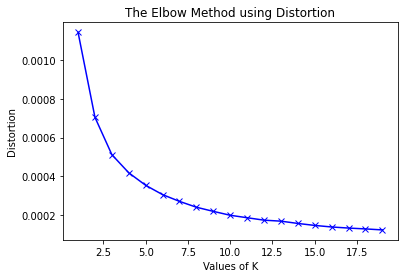

In [351]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [365]:
X_ = pd.concat([train[['id','upper_age','lower_age','reco_policy_premium']],test[['id','upper_age','lower_age','reco_policy_premium']]])
X_['id'] = X_['id'].astype(int)
kmean = KMeans(n_clusters=7)
X_['classes3'] = kmean.fit_predict(normalizer.fit_transform(X_[['upper_age','lower_age','reco_policy_premium']]))

In [366]:
train.drop('classes3',axis=1,inplace=True)
test.drop('classes3',axis=1,inplace=True)

In [367]:
train = pd.merge(left=train, right = X_[['id','classes3']], on='id', how='left')
test = pd.merge(left=test, right = X_[['id','classes3']], on='id', how='left')

In [368]:
train.groupby('classes3').apply(lambda data: data['response'].sum()*100/data['response'].count())

classes3
0    24.074404
1    23.723790
2    23.590533
3    24.276067
4    25.617685
5    21.829653
6    23.852144
dtype: float64

In [369]:
train['classes3'].value_counts()

0    11236
6    11173
1     9109
3     8737
2     5197
4     3845
5     1585
Name: classes3, dtype: int64

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


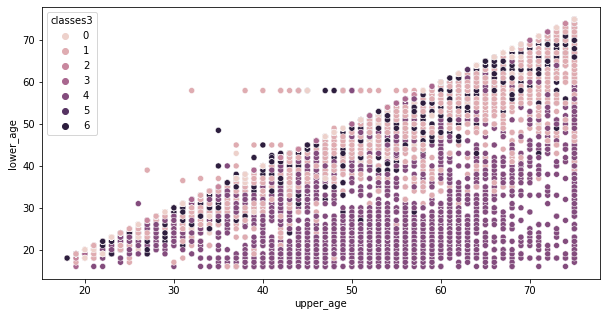

In [373]:
plt.figure(figsize=(10,5))
sns.scatterplot(train['upper_age'],train['lower_age'],hue = 'classes3',data=train)

And here is the the final Modelling.

In [408]:
cat_features = ['city_code','region_code','accomodation_type', 'holding_policy_duration', 'holding_policy_type',
                'reco_policy_cat', 'health indicator','classes', 'classes2', 'classes3']

In [409]:
X = train[['city_code','region_code','accomodation_type','upper_age', 'lower_age','holding_policy_duration',
           'holding_policy_type','reco_policy_cat', 'reco_policy_premium','premium_median',
           'health indicator','classes','classes2','classes3']].copy()
y = train['response'].copy()

In [410]:
cv = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)

In [411]:
i=0
train_scores=[]
val_scores=[]
models = []

(40705, 14)
(10177, 14)


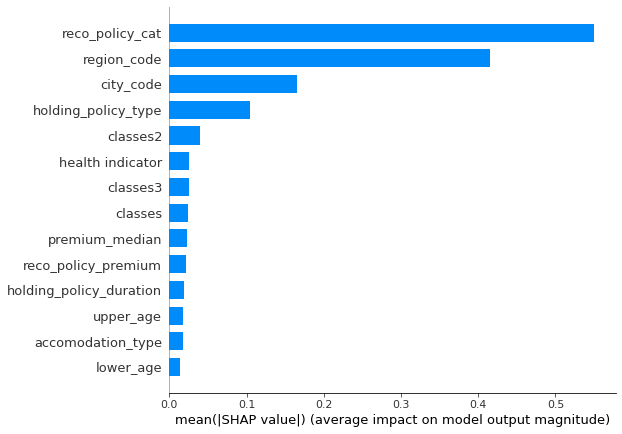

Iteration :0
(40705, 14)
(10177, 14)


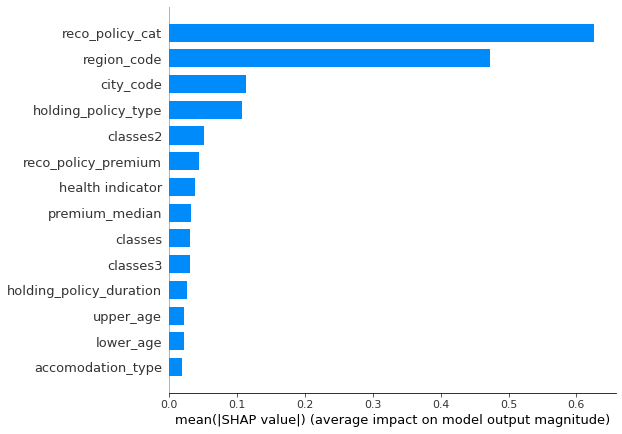

Iteration :1
(40706, 14)
(10176, 14)


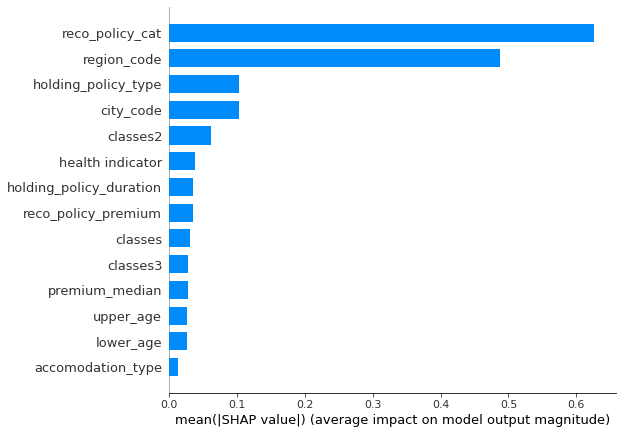

Iteration :2
(40706, 14)
(10176, 14)


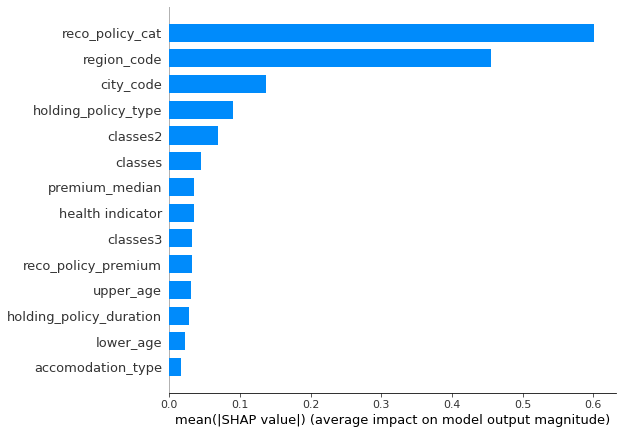

Iteration :3
(40706, 14)
(10176, 14)


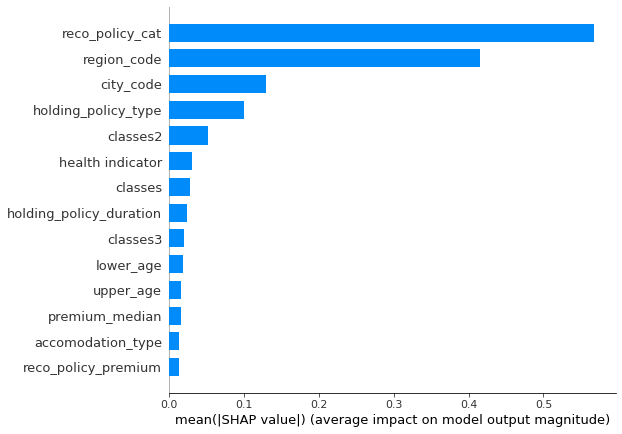

Iteration :4


In [412]:
for train_index,test_index in cv.split(X,y):
  X_train, X_val = X.iloc[train_index], X.iloc[test_index]
  y_train, y_val = y.iloc[train_index], y.iloc[test_index]
  print(X_train.shape)
  print(X_val.shape)
  model = CatBoostClassifier(iterations=5000,
                           learning_rate =0.05,
                           cat_features=cat_features,
                           od_type='Iter',
                           random_seed=1,
                           use_best_model=True,
                           eval_metric='AUC',
                           depth=10,
                           custom_metric='AUC',
                           thread_count=-1,
                           l2_leaf_reg=6
                           )
  model.fit(X_train,
          y_train,
          eval_set =(X_train,y_train),
          cat_features=cat_features,
          use_best_model=True,
          verbose=False,
          plot=False)
  train_scores.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
  val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features))
  shap.summary_plot(shap_values, X_train,plot_type='bar')
  models.append(model)
  print(f'Iteration :{i}')
  i = i+1

In [413]:
np.mean(val_scores)

0.7992871336738243

In [414]:
np.mean(train_scores)

0.9098386051874124

In [415]:
X_test = test[['city_code','region_code','accomodation_type','upper_age', 'lower_age','holding_policy_duration',
           'holding_policy_type','reco_policy_cat', 'reco_policy_premium','premium_median',
           'health indicator','classes','classes2','classes3']].copy()

In [416]:
test['Response'] = np.mean([model.predict_proba(X_test)[:,1] for model in models],axis=0)
test['ID'] = test['id']

In [417]:
test[['ID','Response']].to_csv('9.csv',index=False)